In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from simulator import get_simulator
from simulate import simulate
from simulate import mpi_simulate

In [2]:
system = {
    'duration': 999.0, 
    'resolution': 1.0,
    'species': [
        ('i', 0),
        ('I', 0),
        ('a', 0), 
        ('A', 0),
        ('C', 0),
        ('CC', 0),
        ('t', 0), 
        ('T', 0), 
        ('TT', 0),
    ],
    'reactions': [
        ('sigma_i', (), ((1, 'i'), )), 
        ('alpha_i', ((1, 'i'), ), ((1, 'i'), (1, 'I'))), 
        ('F_i', ((1, 'i'), ), ()), 
        ('Gamma', ((1, 'i'), ), ()), 
        ('G_I', ((1, 'I'), ), ()), 
        ('Gamma', ((1, 'I'), ), ()), 

        ('lambda_ta', (), ((1, 't'), (1, 'a'))), 
        ('alpha_a', ((1, 'a'), ), ((1, 'a'), (1, 'A'))), 
        ('alpha_t', ((1, 't'), ), ((1, 't'), (1, 'T'))), 
        ('F_a', ((1, 'a'), ), ()), 
        ('F_t', ((1, 't'), ), ()), 
        ('Gamma', ((1, 'a'), ), ()), 
        ('Gamma', ((1, 't'), ), ()), 
        ('G_A', ((1, 'A'), ), ()), 
        ('G_T', ((1, 'T'), ), ()), 
        ('G_T', ((1, 'TT'), ), ((1, 'T'), )), 
        ('Gamma', ((1, 'A'), ), ()), 
        ('Gamma', ((1, 'T'), ), ()), 

        ('k_C', ((2, 'T'), ), ((1, 'TT'), )), 
        ('k_C', ((1, 'TT'), (1, 'A')), ((1, 'C'), )), 
        ('k_C', ((2, 'C'), ), ((1, 'CC'), )), 
        ('G_C', ((1, 'C'), ), ((1, 'TT'), )), 
        ('G_C', ((1, 'CC'), ), ((1, 'TT'), (1, 'C'))), 
        ('Gamma', ((1, 'TT'), ), ()), 
        ('Gamma', ((1, 'C'), ), ()), 
        ('Gamma', ((1, 'CC'), ), ()), 
        
    ], 
    'variables': [
        ('sigma_i', 20.0), 
        ('alpha_i', 200.0), 
        ('mu_i', 5.0), 
        ('sigma', 20.0), 
        ('k_0', 0.05), 
        ('alpha_t', 200.0), 
        ('nu', 1.6), 
        ('k_C', 1000.0), 
        ('mu_ta', 5.0), 
        ('f_T', 20.0), # change to beta_T
        ('omega', 0.2), 
        ('delta', 1.5),
        ('mu', 100.0), 
        #('mu', 50.0), 
        ('epsilon', 0.01), 
        ('kappa_M', 1.0),
        ('kappa_I', 1.0), 
        ('eta_p', 0.5), 
        ('kappa_A', 1.0), 
        ('kappa_C', 0.1), 
        ('kappa_T', 0.0), 
        #('kappa_T1', 0.0), 
        #('kappa_T2', 0.0), 
        ('eta_t', 0.5), 
        ('gamma', 1.0), 
        ('phi', 1.0), 
        ('b_c', 0.25), # change to beta_g
    ], 
    'functions': [
        ('alpha_a', 'alpha_t * nu'), 
        ('T_free', 'T + TT'), 
        ('lambda_ta', 'sigma / (1 + k_0 * (A + C + CC))'), 
        ('F_t', 'mu_ta + f_T * (T + TT)'), # change to beta_t 
        ('F_a', 'mu_ta + f_T * (T + TT) * omega'), # change to beta_a
        ('F_i', 'mu_i  + f_T * (T + TT) * delta'),
        ('G1', 'mu / (epsilon + (kappa_I_c * kappa_I) * I + (kappa_M_c * kappa_M) * (kappa_A * A + kappa_C * (C + CC) + (kappa_T1 * kappa_T) * (T + TT)))'),
        ('G2', 'mu / (epsilon + (kappa_I_c * kappa_I) * I + (kappa_M_c * kappa_M) * (kappa_A * A + kappa_C * (C + CC) + (kappa_T2 * kappa_T) * (T + TT)))'),
        ('G_I', 'kappa_I_c * kappa_I * (G1 + G2)'),
        ('G_A', 'kappa_M_c * kappa_M * kappa_A * (G1 + G2)'),
        ('G_C', 'kappa_M_c * kappa_M * kappa_C * (G1 + G2)'),
        ('G_T', 'kappa_M_c * kappa_M * kappa_T * (kappa_T1 * G1 + kappa_T2 * G2)'),
        ('Gamma', '(gamma * phi) / (1.0 + b_c * phi * (T + TT))'),
        ('kappa_M_c', 'eta_p'),
        ('kappa_I_c', '1.0 - eta_p'),
        ('kappa_T1', 'eta_t'),
        ('kappa_T2', '1.0 - eta_t'),
    ], 
    'targets': [
        'time', 
        'i', 
        'I',
        'A',
        'C',
        'CC',
        'T', 
        'TT',
        'T_free',
    ],
}

In [ ]:
df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], get_simulator(system)(0))))
df.plot(x='time', y=['T_free', 'i', 'I'], kind='line', figsize=(12, 8))

In [3]:
def unpack_event_detection(location, outputs, targets):
    for target in targets:
        target_index = system['targets'].index(target)
        measurements = outputs['measurements'][target_index]
        measurements = pd.DataFrame(measurements)
        events = outputs['events'][target_index]
        if events and sum([len(e) for e in events]):            
            values = np.average(measurements, weights=measurements['Event Count'], axis=0)
            values[-1] = measurements['Event Count'].sum()
        else:
            values = np.array((-1, -1, -1, 0, 0))
        entry = location.copy()
        entry['Target'] = target
        for j, m in enumerate(measurements):
            entry[m] = values[j]
        yield entry

In [4]:
def pscan_view(pscan, subspace, targets):
    subpscan = tuple(((pscan[k] == v) for k, v in subspace.items()))
    subpscan = np.bitwise_and.reduce(subpscan) if subpscan else True
    istarget = pscan['Target'].apply(lambda t: t in set(targets))    
    selection = pscan.loc[istarget & subpscan]
    return selection

In [5]:
from event_detection import event_detection

processing = (event_detection, )

axes = (
    #('sigma_i', np.arange(0.0, 20.0 + 1.0, 1.0)),
    
    #('mu', (50, 100)),

    #('kappa_I', (0, 1)),

    #('kappa_T', (0, 0.0000001, 0.000001, 0.00001)),
    
    #('eta_p', (0, 0.5)),
    ('eta_p', np.arange(0.0, 1.0 + 0.1, 0.2)),

    #('eta_t', (0, 0.5, 1)),
    #('eta_t', np.arange(0.0, 1.0 + 0.1, 0.1)),
)

#pspace, data = simulate(system, processing=processing, batchsize=10, axes=axes)
pspace, data = mpi_simulate(system, processing=processing, batchsize=10, axes=axes)

worker 6 start
worker 7 start
start dispatch 0 ./.simulators/run.json
setting up workers
worker 4 start
worker 2 start
worker 3 start
worker 1 start
worker 5 start
worker 1 setting up
ext module version: gillespie_0 0
Compiling ./gillespie_0.pyx because it changed.
[1/1] Cythonizing ./gillespie_0.pyx
running clean
removing 'build/temp.linux-x86_64-3.6' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_0' extension
creating build/temp.linux-x86_64-3.6
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/cogle/dev/budget/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/cogle/dev/budget/anaconda3/include/python3.6m -c ./gillespie_0.c -o build/temp.linux-x86_64-3.6/./gillespie_0.o
gcc -pthread -shared -L/home/cogle/dev/budget/anaconda3/lib -Wl,-rpath=/home/cogle/dev/budget/anaconda3/lib,--no-as-needed build/temp.linux-x86_64-3.6/./gillespie_0.o -L/home/cogle/dev/budget/anaconda3/lib -lpython3.6m -o /home/

In [6]:
processing = 0
#targets = ('T_free', )
targets = system['targets'][1:]

entries = []
for (l, location) in pd.DataFrame(pspace).iterrows():
    outputs = data[l][processing]
    for entry in unpack_event_detection(location, outputs, targets):
        entries.append(entry)
pscan = pd.DataFrame(entries)

pscan.shape, pscan.columns

((48, 7), Index(['eta_p', 'Target', 'Mean Event Duration', 'Mean Event Height',
        'StdDev Event Height', 'Toxic Probability', 'Event Count'],
       dtype='object'))

In [7]:
subspace = {
    #'Target': 'T_free', 

    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    #'kappa_I': 0, 
    #'eta_t': 0.5, 
}

targets = ('T_free', 'I')

selection = pscan_view(pscan, subspace, targets)

selection.shape, selection.columns

((12, 7), Index(['eta_p', 'Target', 'Mean Event Duration', 'Mean Event Height',
        'StdDev Event Height', 'Toxic Probability', 'Event Count'],
       dtype='object'))

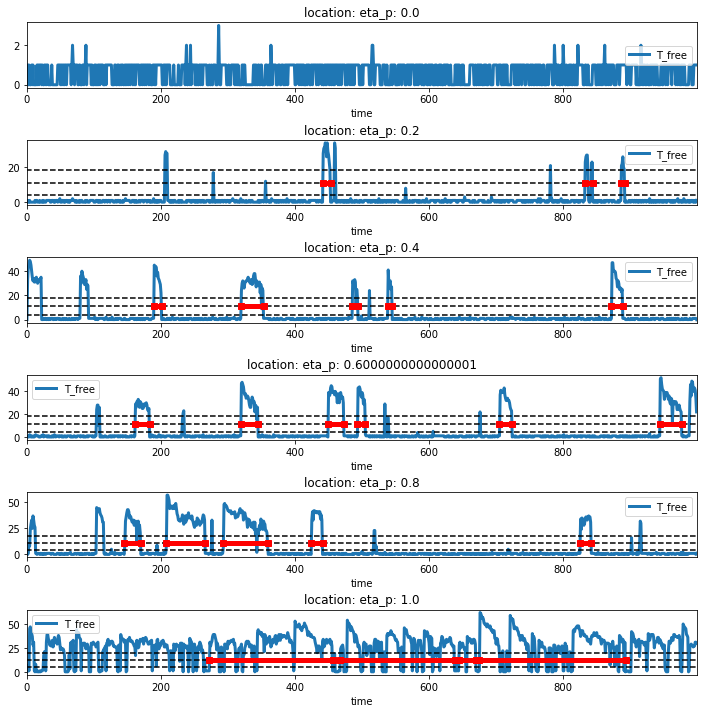

In [8]:
processing = 0
trajectory = 0
target = 'T_free'


target_selection = selection.loc[selection['Target'] == target].reset_index()
target_index = system['targets'].index(target)

pspace_df = pd.DataFrame(pspace)
n_fig = target_selection.shape[0]
f, axes = plt.subplots(n_fig, 1, figsize=(12, 2 * n_fig))
f.subplots_adjust(wspace=0.8, hspace=0.8)
for (l, location), ax in zip(target_selection.iterrows(), axes):
    location = location[pspace_df.columns]
    location = ', '.join(('%s: %s' % (i, j)) for i, j in zip(location.index, location.values))
    ax.set_title('location: %s' % location)

    outputs = data[l][processing]
    counts = outputs['batch'][trajectory, :, :]

    df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], counts)))
    df.plot(x='time', y=[target], kind='line', lw=3, ax=ax)

    measurements = pd.DataFrame(outputs['measurements'][target_index])
    events = outputs['events'][target_index]
    if events and sum([len(e) for e in events]):
        parameters = outputs['parameters'][target_index]
        high, low = parameters['high'], parameters['low']
        medium = (high + low) / 2.0
        time = counts[0, :]
        ax.plot([time[0] - 1, time[-1] + 1], [low, low], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [medium, medium], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [high, high], color='k', ls='--')
        for i, j in events[trajectory]:
            ax.plot([time[i], time[j]], [medium, medium], color='r', lw=5, marker='s')

0    0.0
1    0.2
2    0.4
3    0.6
4    0.8
5    1.0
Name: eta_p, dtype: float64


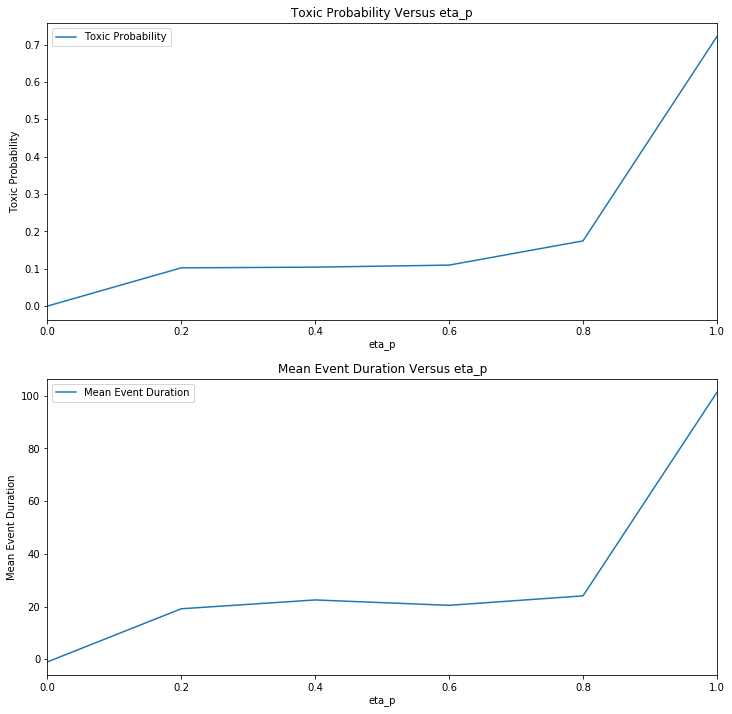

In [9]:
x = 'eta_p'
ys = [['Toxic Probability'], ['Mean Event Duration']]

print(target_selection[x])

n = len(ys)
f, axes = plt.subplots(n, 1, figsize=(12, n * 6))
for ax, targets in zip(axes, ys):
    target_selection.plot(x=x, y=targets, ax=ax)
    ax.set_title('%s Versus %s' % (', '.join(targets), x))
    ax.set_xlabel(x)
    ax.set_ylabel(', '.join(targets))